In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchinfo import summary

from src.const import SEED
from src.evaluation import eval_acc_in_binary_task
from src.preprocess import transform_to_data_loader, preprocess_silence
from src.train import train_model
from src.visualization import plot_conf_matrix, plot_losses

Before running this notebook you must run `Preprocess.ipynb` notebook to prepare every dataset used here!!!

In [2]:
CLASSES = ['silence', 'sound']

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load and preprocess data

In [4]:
sound = np.load('data/arrays/X_train.npy')
silence = np.load("silence.npy")

silence = preprocess_silence(silence)

sound_indices = random.sample(range(1, sound.shape[0]), silence.shape[0])
sound = sound[sound_indices]

X_silence = np.concatenate((silence, sound), 0)
y_silence = np.concatenate((np.ones(silence.shape[0]), np.zeros(sound.shape[0])), 0)

Processing...: 100%|██████████| 4378/4378 [00:07<00:00, 610.49it/s]


Split for train and validation

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_silence, y_silence, test_size=0.2, random_state=42
)

Generate data loaders for train and validation

In [6]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

In [7]:
for x, y in train_dl:
    print(f'Input size: {x.shape}')
    print(f'Labels size: {y.shape}')
    break

Input size: torch.Size([128, 99, 20])
Labels size: torch.Size([128])


## Models

### Transformer

In [8]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, n_head, num_layers, dropout_rate=0.3, units=16):
        
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.trans_enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True, activation="relu").to(device)
        self.transformer_encoder = nn.TransformerEncoder(self.trans_enc_layer, num_layers=num_layers).to(device)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(d_model, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(d_model)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.transformer_encoder(x)[:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [9]:
d_model = 20
n_head = 4
num_layers = 1

transformer_model = Transformer(d_model, n_head, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(transformer_model.parameters(), weight_decay=1e-5)

c:\Users\izate\anaconda3\envs\dl2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\izate\anaconda3\envs\dl2\lib\site-packages\transformers\utils\generic.py:485: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [10]:
summary(transformer_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [128, 1]                  85,748
├─TransformerEncoder: 1-1                     [128, 99, 20]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [128, 99, 20]             85,748
├─Dropout: 1-2                                [128, 20]                 --
├─BatchNorm1d: 1-3                            [128, 20]                 40
├─Linear: 1-4                                 [128, 16]                 336
├─Dropout: 1-5                                [128, 16]                 --
├─ReLU: 1-6                                   [128, 16]                 --
├─BatchNorm1d: 1-7                            [128, 16]                 32
├─Linear: 1-8                                 [128, 1]                  17
├─Sigmoid: 1-9                                [128, 1]                  --
Total param

In [11]:
train_losses, val_losses = train_model(
    model=transformer_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1:   0%|          | 0/55 [00:00<?, ?it/s]c:\Users\izate\anaconda3\envs\dl2\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1: 100%|██████████| 55/55 [00:00<00:00, 63.22it/s]


Epoch 1/50, Train Loss: 0.6079, Train Acc: 0.67, Val Loss: 0.5047, Val Acc: 0.76


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 75.65it/s]


Epoch 2/50, Train Loss: 0.4832, Train Acc: 0.78, Val Loss: 0.4043, Val Acc: 0.81


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 75.58it/s]


Epoch 3/50, Train Loss: 0.3519, Train Acc: 0.87, Val Loss: 0.2300, Val Acc: 0.92


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 75.53it/s]


Epoch 4/50, Train Loss: 0.2219, Train Acc: 0.93, Val Loss: 0.1467, Val Acc: 0.94


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 75.33it/s]


Epoch 5/50, Train Loss: 0.1507, Train Acc: 0.96, Val Loss: 0.1122, Val Acc: 0.97


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 75.76it/s]


Epoch 6/50, Train Loss: 0.1208, Train Acc: 0.97, Val Loss: 0.0924, Val Acc: 0.97


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 74.68it/s]


Epoch 7/50, Train Loss: 0.0999, Train Acc: 0.97, Val Loss: 0.0971, Val Acc: 0.97


Epoch 8: 100%|██████████| 55/55 [00:00<00:00, 72.93it/s]


Epoch 8/50, Train Loss: 0.0887, Train Acc: 0.98, Val Loss: 0.0879, Val Acc: 0.97


Epoch 9: 100%|██████████| 55/55 [00:00<00:00, 75.51it/s]


Epoch 9/50, Train Loss: 0.0766, Train Acc: 0.98, Val Loss: 0.0732, Val Acc: 0.98


Epoch 10: 100%|██████████| 55/55 [00:00<00:00, 75.86it/s]


Epoch 10/50, Train Loss: 0.0672, Train Acc: 0.98, Val Loss: 0.0749, Val Acc: 0.98


Epoch 11: 100%|██████████| 55/55 [00:00<00:00, 75.77it/s]


Epoch 11/50, Train Loss: 0.0683, Train Acc: 0.98, Val Loss: 0.1111, Val Acc: 0.97


Epoch 12: 100%|██████████| 55/55 [00:00<00:00, 75.11it/s]


Epoch 12/50, Train Loss: 0.0584, Train Acc: 0.98, Val Loss: 0.0661, Val Acc: 0.98


Epoch 13: 100%|██████████| 55/55 [00:00<00:00, 75.85it/s]


Epoch 13/50, Train Loss: 0.0522, Train Acc: 0.99, Val Loss: 0.0690, Val Acc: 0.98


Epoch 14: 100%|██████████| 55/55 [00:00<00:00, 73.49it/s]


Epoch 14/50, Train Loss: 0.0495, Train Acc: 0.99, Val Loss: 0.0830, Val Acc: 0.98


Epoch 15: 100%|██████████| 55/55 [00:00<00:00, 73.59it/s]


Epoch 15/50, Train Loss: 0.0482, Train Acc: 0.99, Val Loss: 0.0567, Val Acc: 0.98


Epoch 16: 100%|██████████| 55/55 [00:00<00:00, 75.83it/s]


Epoch 16/50, Train Loss: 0.0404, Train Acc: 0.99, Val Loss: 0.0734, Val Acc: 0.98


Epoch 17: 100%|██████████| 55/55 [00:00<00:00, 73.99it/s]


Epoch 17/50, Train Loss: 0.0394, Train Acc: 0.99, Val Loss: 0.0688, Val Acc: 0.99


Epoch 18: 100%|██████████| 55/55 [00:00<00:00, 75.39it/s]

Epoch 18/50, Train Loss: 0.0337, Train Acc: 0.99, Val Loss: 0.0618, Val Acc: 0.99
Early stopping


#### Evaluation

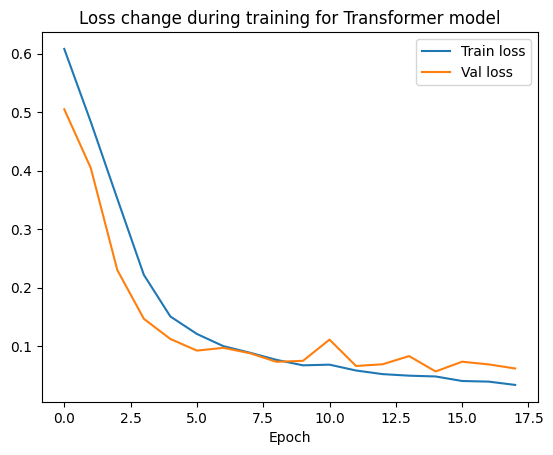

In [12]:
plot_losses(train_losses, val_losses, "Loss change during training for Transformer model")

In [13]:
eval_acc_in_binary_task(transformer_model, X_train, y_train, 'Train', device)
y_pred, acc = eval_acc_in_binary_task(transformer_model, X_val, y_val, 'Validation', device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 5.29 GiB. GPU 0 has a total capacity of 6.00 GiB of which 0 bytes is free. Of the allocated memory 6.85 GiB is allocated by PyTorch, and 1.21 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
plot_conf_matrix(y_val, y_pred, CLASSES)

### GRU

In [67]:
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=4, units=64, dropout_rate=0.3):
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(hidden_size)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.gru(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [74]:
input_size = 20
hidden_size = 16
num_layers = 2

gru_model = GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(gru_model.parameters(), weight_decay=1e-5)

In [75]:
summary(gru_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [128, 1]                  --
├─GRU: 1-1                               [128, 99, 16]             3,456
├─Dropout: 1-2                           [128, 16]                 --
├─BatchNorm1d: 1-3                       [128, 16]                 32
├─Linear: 1-4                            [128, 64]                 1,088
├─Dropout: 1-5                           [128, 64]                 --
├─ReLU: 1-6                              [128, 64]                 --
├─BatchNorm1d: 1-7                       [128, 64]                 128
├─Linear: 1-8                            [128, 1]                  65
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
Total mult-adds (M): 43.96
Input size (MB): 1.01
Forward/backward pass size (MB): 1.77
Params size (MB): 0.02
Estimated Total Size (MB): 2.80

In [76]:
train_losses, val_losses = train_model(
    model=gru_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1: 100%|██████████| 55/55 [00:00<00:00, 110.60it/s]


Epoch 1/50, Train Loss: 0.6406, Train Acc: 0.62, Val Loss: 0.5393, Val Acc: 0.75


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 154.17it/s]


Epoch 2/50, Train Loss: 0.5052, Train Acc: 0.76, Val Loss: 0.4889, Val Acc: 0.77


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 163.39it/s]


Epoch 3/50, Train Loss: 0.4484, Train Acc: 0.79, Val Loss: 0.4601, Val Acc: 0.79


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 157.92it/s]


Epoch 4/50, Train Loss: 0.4167, Train Acc: 0.82, Val Loss: 0.4199, Val Acc: 0.81


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 165.94it/s]


Epoch 5/50, Train Loss: 0.3511, Train Acc: 0.85, Val Loss: 0.2607, Val Acc: 0.89


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 147.50it/s]


Epoch 6/50, Train Loss: 0.1885, Train Acc: 0.94, Val Loss: 0.1411, Val Acc: 0.95


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 162.38it/s]


Epoch 7/50, Train Loss: 0.1149, Train Acc: 0.97, Val Loss: 0.0987, Val Acc: 0.97


Epoch 8: 100%|██████████| 55/55 [00:00<00:00, 163.86it/s]


Epoch 8/50, Train Loss: 0.1012, Train Acc: 0.97, Val Loss: 0.0877, Val Acc: 0.97


Epoch 9: 100%|██████████| 55/55 [00:00<00:00, 162.59it/s]


Epoch 9/50, Train Loss: 0.0903, Train Acc: 0.98, Val Loss: 0.0790, Val Acc: 0.98


Epoch 10: 100%|██████████| 55/55 [00:00<00:00, 153.33it/s]


Epoch 10/50, Train Loss: 0.0818, Train Acc: 0.98, Val Loss: 0.0711, Val Acc: 0.98


Epoch 11: 100%|██████████| 55/55 [00:00<00:00, 146.46it/s]


Epoch 11/50, Train Loss: 0.0760, Train Acc: 0.98, Val Loss: 0.0651, Val Acc: 0.98


Epoch 12: 100%|██████████| 55/55 [00:00<00:00, 159.30it/s]


Epoch 12/50, Train Loss: 0.0739, Train Acc: 0.98, Val Loss: 0.0687, Val Acc: 0.98


Epoch 13: 100%|██████████| 55/55 [00:00<00:00, 162.65it/s]


Epoch 13/50, Train Loss: 0.0687, Train Acc: 0.99, Val Loss: 0.0687, Val Acc: 0.98


Epoch 14: 100%|██████████| 55/55 [00:00<00:00, 159.60it/s]

Epoch 14/50, Train Loss: 0.0683, Train Acc: 0.99, Val Loss: 0.0685, Val Acc: 0.98
Early stopping


#### Evaluation

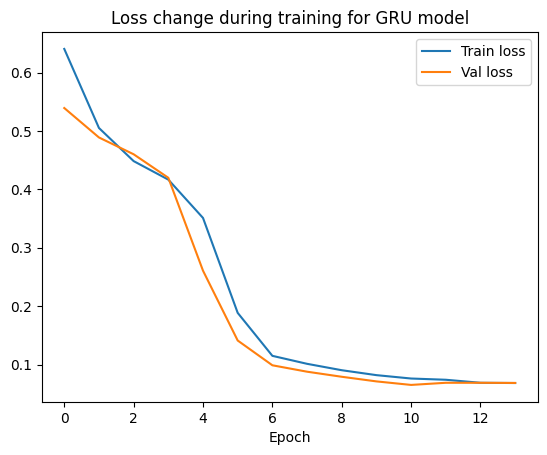

In [77]:
plot_losses(train_losses, val_losses, "Loss change during training for GRU model")

In [72]:
eval_acc_in_binary_task(gru_model, X_train, y_train, 'Train', device)
y_pred, acc = eval_acc_in_binary_task(gru_model, X_val, y_val, 'Validation', device)

Train accuracy: 0.9969
Validation accuracy: 0.9909


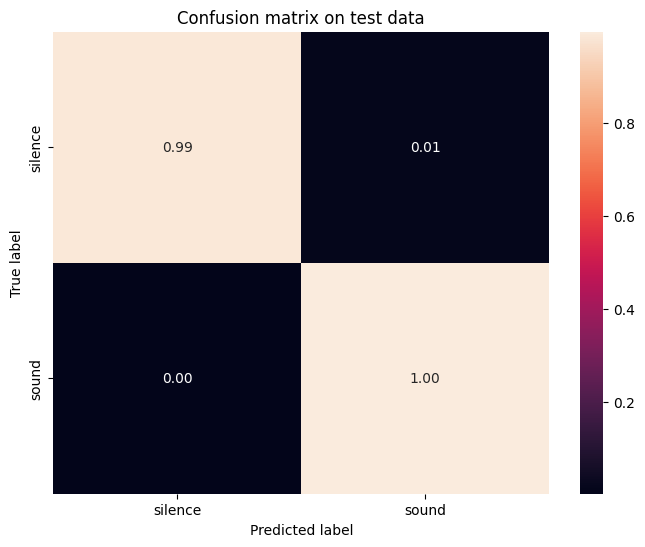

In [78]:
plot_conf_matrix(y_val, y_pred, CLASSES)

### BI-LSTM

In [122]:
class BiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=4, units=16, dropout_rate=0.2):
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True, 
            num_layers=num_layers,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(2*hidden_size, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(2*hidden_size)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.lstm(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [123]:
input_size = 20
hidden_size = 16
num_layers = 2

bilstm_model = BiLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), weight_decay=1e-5)

In [124]:
summary(bilstm_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [128, 1]                  --
├─LSTM: 1-1                              [128, 99, 32]             11,264
├─Dropout: 1-2                           [128, 32]                 --
├─BatchNorm1d: 1-3                       [128, 32]                 64
├─Linear: 1-4                            [128, 16]                 528
├─Dropout: 1-5                           [128, 16]                 --
├─ReLU: 1-6                              [128, 16]                 --
├─BatchNorm1d: 1-7                       [128, 16]                 32
├─Linear: 1-8                            [128, 1]                  17
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
Total mult-adds (M): 142.82
Input size (MB): 1.01
Forward/backward pass size (MB): 3.31
Params size (MB): 0.05
Estimated Total Size (MB): 4.37

In [125]:
train_losses, val_losses = train_model(
    model=bilstm_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1: 100%|██████████| 55/55 [00:00<00:00, 106.44it/s]


Epoch 1/50, Train Loss: 0.6323, Train Acc: 0.64, Val Loss: 0.5556, Val Acc: 0.77


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 146.04it/s]


Epoch 2/50, Train Loss: 0.4800, Train Acc: 0.79, Val Loss: 0.4335, Val Acc: 0.81


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 149.98it/s]


Epoch 3/50, Train Loss: 0.3984, Train Acc: 0.84, Val Loss: 0.3441, Val Acc: 0.85


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 143.98it/s]


Epoch 4/50, Train Loss: 0.2963, Train Acc: 0.90, Val Loss: 0.2821, Val Acc: 0.89


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 143.61it/s]


Epoch 5/50, Train Loss: 0.2306, Train Acc: 0.93, Val Loss: 0.2116, Val Acc: 0.93


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 147.00it/s]


Epoch 6/50, Train Loss: 0.2263, Train Acc: 0.93, Val Loss: 0.1969, Val Acc: 0.93


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 145.42it/s]


Epoch 7/50, Train Loss: 0.1811, Train Acc: 0.94, Val Loss: 0.1252, Val Acc: 0.96


Epoch 8: 100%|██████████| 55/55 [00:00<00:00, 141.37it/s]


Epoch 8/50, Train Loss: 0.1562, Train Acc: 0.95, Val Loss: 0.1569, Val Acc: 0.94


Epoch 9: 100%|██████████| 55/55 [00:00<00:00, 139.25it/s]


Epoch 9/50, Train Loss: 0.1343, Train Acc: 0.96, Val Loss: 0.1104, Val Acc: 0.97


Epoch 10: 100%|██████████| 55/55 [00:00<00:00, 140.89it/s]


Epoch 10/50, Train Loss: 0.1185, Train Acc: 0.97, Val Loss: 0.1234, Val Acc: 0.96


Epoch 11: 100%|██████████| 55/55 [00:00<00:00, 145.06it/s]


Epoch 11/50, Train Loss: 0.1241, Train Acc: 0.96, Val Loss: 0.0953, Val Acc: 0.97


Epoch 12: 100%|██████████| 55/55 [00:00<00:00, 146.34it/s]


Epoch 12/50, Train Loss: 0.1078, Train Acc: 0.97, Val Loss: 0.1236, Val Acc: 0.96


Epoch 13: 100%|██████████| 55/55 [00:00<00:00, 144.21it/s]


Epoch 13/50, Train Loss: 0.0942, Train Acc: 0.97, Val Loss: 0.0790, Val Acc: 0.98


Epoch 14: 100%|██████████| 55/55 [00:00<00:00, 144.84it/s]


Epoch 14/50, Train Loss: 0.0846, Train Acc: 0.98, Val Loss: 0.0799, Val Acc: 0.98


Epoch 15: 100%|██████████| 55/55 [00:00<00:00, 140.87it/s]


Epoch 15/50, Train Loss: 0.0766, Train Acc: 0.98, Val Loss: 0.0742, Val Acc: 0.98


Epoch 16: 100%|██████████| 55/55 [00:00<00:00, 149.26it/s]


Epoch 16/50, Train Loss: 0.0692, Train Acc: 0.98, Val Loss: 0.0973, Val Acc: 0.97


Epoch 17: 100%|██████████| 55/55 [00:00<00:00, 143.57it/s]


Epoch 17/50, Train Loss: 0.0734, Train Acc: 0.98, Val Loss: 0.0591, Val Acc: 0.99


Epoch 18: 100%|██████████| 55/55 [00:00<00:00, 142.25it/s]


Epoch 18/50, Train Loss: 0.0737, Train Acc: 0.98, Val Loss: 0.0715, Val Acc: 0.98


Epoch 19: 100%|██████████| 55/55 [00:00<00:00, 146.15it/s]


Epoch 19/50, Train Loss: 0.0599, Train Acc: 0.99, Val Loss: 0.0907, Val Acc: 0.98


Epoch 20: 100%|██████████| 55/55 [00:00<00:00, 132.37it/s]


Epoch 20/50, Train Loss: 0.0674, Train Acc: 0.98, Val Loss: 0.0489, Val Acc: 0.99


Epoch 21: 100%|██████████| 55/55 [00:00<00:00, 135.26it/s]


Epoch 21/50, Train Loss: 0.0495, Train Acc: 0.99, Val Loss: 0.0487, Val Acc: 0.99


Epoch 22: 100%|██████████| 55/55 [00:00<00:00, 126.72it/s]


Epoch 22/50, Train Loss: 0.0521, Train Acc: 0.99, Val Loss: 0.0479, Val Acc: 0.99


Epoch 23: 100%|██████████| 55/55 [00:00<00:00, 142.06it/s]


Epoch 23/50, Train Loss: 0.0536, Train Acc: 0.99, Val Loss: 0.0490, Val Acc: 0.99


Epoch 24: 100%|██████████| 55/55 [00:00<00:00, 142.73it/s]


Epoch 24/50, Train Loss: 0.0482, Train Acc: 0.99, Val Loss: 0.1613, Val Acc: 0.95


Epoch 25: 100%|██████████| 55/55 [00:00<00:00, 141.40it/s]

Epoch 25/50, Train Loss: 0.0533, Train Acc: 0.99, Val Loss: 0.0514, Val Acc: 0.99
Early stopping


#### Evaluation

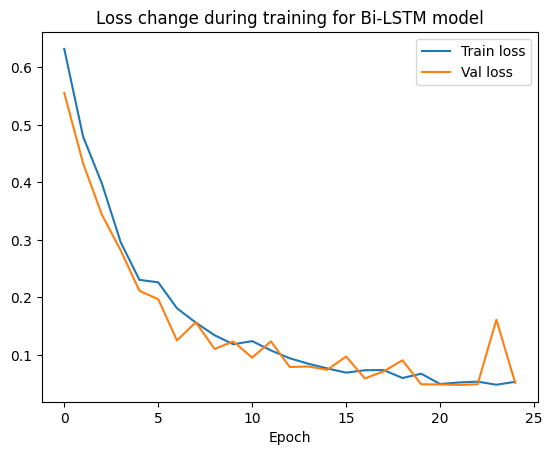

In [126]:
plot_losses(train_losses, val_losses, "Loss change during training for Bi-LSTM model")

In [127]:
eval_acc_in_binary_task(bilstm_model, X_train, y_train, 'Train', device)
y_pred, acc = eval_acc_in_binary_task(bilstm_model, X_val, y_val, 'Validation', device)

Train accuracy: 0.9946
Validation accuracy: 0.9869


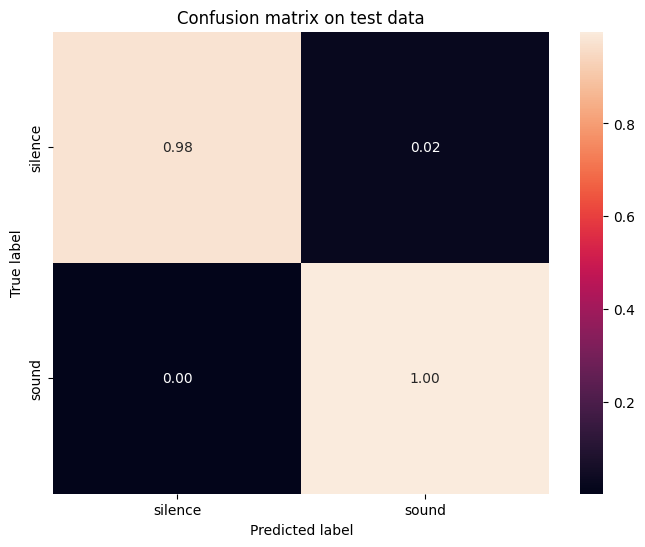

In [128]:
plot_conf_matrix(y_val, y_pred, CLASSES)